In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import pandas as pd
from termcolor import colored
import numpy as np
from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt
from natsort import natsorted
import sys
import pickle
import seaborn as sns

# Display pandas df without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))



In [3]:
num_robot = 24
fieldsPerKilobot = 6
experiment_time = 1800
num_run = 100

num_areas = 16
fieldsPerArea = 6 #id, posx, posy, color, completed?, #kilo_in_area

In [4]:
completed_task_label = ["time", "areaID", "creation_time", "completion_time", "type", "kID_on_top", "kIDs"]

In [5]:
results_folders = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/adaptiveTimeout/'

In [6]:
#WARNING: be carefull if in the entire run no red/blue area is completed        

step = 50
bin_edges = np.arange(0,1800+step,step)

cumsums = {}

for results_folder in os.listdir(results_folders):
    
    cumsum_red = np.array([])
    cumsum_blue = np.array([])
    
    for timeout_folder in natsorted(os.listdir(os.path.join(results_folders,results_folder))):
        timeout = -1
        print(colored("Timeout folder:", 'blue'),timeout_folder)

        parameters = timeout_folder.split("_")

        for param in parameters:
            if param.startswith("timeout"):
                timeout = int(param.split("#")[-1]) * 10
#                 print("\ttimeout:",timeout)


        if timeout == -1 :
            print(colored("\tWARNING: wrong timeout folder", 'green'))
            continue

        exp_config = parameters[0]+"_"+parameters[1]
        cumsums[exp_config] = {}
        print("Exp configuration:",exp_config)
        
        for filename in os.listdir(os.path.join(results_folders, results_folder, timeout_folder)):
            if filename.endswith("completed_taskLOG.tsv"):
                if not os.path.getsize(os.path.join(results_folders, results_folder, timeout_folder, filename)) > 0:
                    print(colored("\tWARNING, empty file at:" + filename, 'red'))
                    continue
#                 print('\tfilename: ', filename)

                df_completedTask = pd.read_csv(os.path.join(results_folders, results_folder, timeout_folder, filename), sep="\t", header=None)
                df_completedTask.columns = completed_task_label


                df_blue = df_completedTask.where(df_completedTask['type'] == 0)
                filtered_blue = df_blue[df_blue['time'].notnull()]

                df_red = df_completedTask.mask(df_completedTask['type'] == 0)
                filtered_red = df_red[df_red['time'].notnull()]

                hist_red,_= np.histogram(filtered_red['time'].values,bin_edges)
                hist_blue,_= np.histogram(filtered_blue['time'].values,bin_edges)

#                 print("hist_red:\n",hist_red)
#                 print("hist_blue:\n",hist_blue)

                cumsum_blue = np.vstack([cumsum_blue, hist_blue.cumsum()]) if cumsum_blue.size else hist_blue.cumsum()
                cumsum_red = np.vstack([cumsum_red, hist_red.cumsum()]) if cumsum_red.size else hist_red.cumsum()

#                 print("cumsum_red:\n",cumsum_red)
#                 print("cumsum_blue:\n",cumsum_blue)

        cumsums[exp_config] = {"blue":[np.mean(cumsum_blue, axis=0),np.std(cumsum_blue, axis=0)],"red":[np.mean(cumsum_red, axis=0),np.std(cumsum_red, axis=0)]}
#         break


Timeout folder: Regions_Adaptive_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
Exp configuration: Regions_Adaptive
Timeout folder: Regions_Brownian_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
Exp configuration: Regions_Brownian
Timeout folder: Regions_Persistent_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
Exp configuration: Regions_Persistent
Timeout folder: Mixed_Adaptive_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
Exp configuration: Mixed_Adaptive
Timeout folder: Mixed_Brownian_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
Exp configuration: Mixed_Brownian
Timeout folder: Mixed_Persistent_2021-07-16_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
Exp configuration: Mixed_Persistent


In [11]:
for key,value in cumsums.items():
    print(key)
    for nested_key, nested_val in value.items():
        print(nested_key, nested_val[0].size, nested_val[1].size)
        

Regions_Adaptive
blue 36 36
red 36 36
Regions_Brownian
blue 36 36
red 36 36
Regions_Persistent
blue 36 36
red 36 36
Mixed_Adaptive
blue 36 36
red 36 36
Mixed_Brownian
blue 36 36
red 36 36
Mixed_Persistent
blue 36 36
red 36 36


In [57]:
def cumulative_plot(cumsums, bin_edges):

    plt.rcParams.update({'font.size': 14})
    
    region_persistent_blue_mean = np.append([0],cumsums["Regions_Persistent"]["blue"][0])
    region_persistent_blue_std = np.append([0],cumsums["Regions_Persistent"]["blue"][1])
    region_persistent_red_mean = np.append([0],cumsums["Regions_Persistent"]["red"][0])
    region_persistent_red_std = np.append([0],cumsums["Regions_Persistent"]["red"][1])

    mixed_persistent_blue_mean = np.append([0],cumsums["Mixed_Persistent"]["blue"][0])
    mixed_persistent_blue_std = np.append([0],cumsums["Mixed_Persistent"]["blue"][1])
    mixed_persistent_red_mean = np.append([0],cumsums["Mixed_Persistent"]["red"][0])
    mixed_persistent_red_std = np.append([0],cumsums["Mixed_Persistent"]["red"][1])


    region_brownian_blue_mean = np.append([0],cumsums["Regions_Brownian"]["blue"][0])
    region_brownian_blue_std = np.append([0],cumsums["Regions_Brownian"]["blue"][1])
    region_brownian_red_mean = np.append([0],cumsums["Regions_Brownian"]["red"][0])
    region_brownian_red_std = np.append([0],cumsums["Regions_Brownian"]["red"][1])

    mixed_brownian_blue_mean = np.append([0],cumsums["Mixed_Brownian"]["blue"][0])
    mixed_brownian_blue_std = np.append([0],cumsums["Mixed_Brownian"]["blue"][1])
    mixed_brownian_red_mean = np.append([0],cumsums["Mixed_Brownian"]["red"][0])
    mixed_brownian_red_std = np.append([0],cumsums["Mixed_Brownian"]["red"][1])


    region_adaptive_blue_mean = np.append([0],cumsums["Regions_Adaptive"]["blue"][0])
    region_adaptive_blue_std = np.append([0],cumsums["Regions_Adaptive"]["blue"][1])
    region_adaptive_red_mean = np.append([0],cumsums["Regions_Adaptive"]["red"][0])
    region_adaptive_red_std = np.append([0],cumsums["Regions_Adaptive"]["red"][1])

    mixed_adaptive_blue_mean = np.append([0],cumsums["Mixed_Adaptive"]["blue"][0])
    mixed_adaptive_blue_std = np.append([0],cumsums["Mixed_Adaptive"]["blue"][1])
    mixed_adaptive_red_mean = np.append([0],cumsums["Mixed_Adaptive"]["red"][0])
    mixed_adaptive_red_std = np.append([0],cumsums["Mixed_Adaptive"]["red"][1])



    fig, ax = plt.subplots(figsize=(25, 10), dpi=80)

    ax.plot(bin_edges, region_persistent_blue_mean, 'r-o', linewidth=1.5, label='Persistent_soft_task')
    ax.fill_between(bin_edges, region_persistent_blue_mean - region_persistent_blue_std, region_persistent_blue_mean + region_persistent_blue_std, alpha=0.2, color="r")
    ax.plot(bin_edges, region_persistent_red_mean, 'r--s', linewidth=1.5, label='Persistent_hard_task')
    ax.fill_between(bin_edges, region_persistent_red_mean - region_persistent_red_std, region_persistent_red_mean + region_persistent_red_std, alpha=0.2, color="r")

    ax.plot(bin_edges, region_brownian_blue_mean, 'b-o', linewidth=1.5, label='Brownian_soft_task')
    ax.fill_between(bin_edges, region_brownian_blue_mean - region_brownian_blue_std, region_brownian_blue_mean + region_brownian_blue_std, alpha=0.2, color="b")
    ax.plot(bin_edges, region_brownian_red_mean, 'b--s', linewidth=1.5, label='Brownian_hard_task')
    ax.fill_between(bin_edges, region_brownian_red_mean - region_brownian_red_std, region_brownian_red_mean + region_brownian_red_std, alpha=0.2, color="b")

    ax.plot(bin_edges, region_adaptive_blue_mean, 'g-o', linewidth=1.5, label='Adaptive_soft_task')
    ax.fill_between(bin_edges, region_adaptive_blue_mean - region_adaptive_blue_std, region_adaptive_blue_mean + region_adaptive_blue_std, alpha=0.2, color="g")
    ax.plot(bin_edges, region_adaptive_red_mean, 'g--s', linewidth=1.5, label='Adaptive_hard_task')
    ax.fill_between(bin_edges, region_adaptive_red_mean - region_adaptive_red_std, region_adaptive_red_mean + region_adaptive_red_std, alpha=0.2, color="g")

    # tidy up the figure
    ax.set_xticks(bin_edges)
    ax.set_xticklabels(bin_edges*10**-2)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_title('Cumulative area completion, timeout: ' + r"$\bf{" + "adaptive" + "}$")
    ax.set_xlabel('Time $10^{-2}$ [s]')
    ax.set_ylabel('Cumulative area completion')
    ax.set_ylim(top=130)
    figName="adaptiveTimeout_cumulativeAreaCompletion_Regions.png"
    print("Saving figure: ", figName)
    
    plt.savefig(figName)
    plt.show()
    
    
    
    
    fig, ax = plt.subplots(figsize=(25, 10), dpi=80)
    
    ax.plot(bin_edges, mixed_persistent_blue_mean, 'r-o', linewidth=1.5, label='Persistent_soft_task')
    ax.fill_between(bin_edges, mixed_persistent_blue_mean - mixed_persistent_blue_std, mixed_persistent_blue_mean + mixed_persistent_blue_std, alpha=0.2, color="r")
    ax.plot(bin_edges, mixed_persistent_red_mean, 'r--s', linewidth=1.5, label='Persistent_hard_task')
    ax.fill_between(bin_edges, mixed_persistent_red_mean - mixed_persistent_red_std, mixed_persistent_red_mean + mixed_persistent_red_std, alpha=0.2, color="r")

    ax.plot(bin_edges, mixed_brownian_blue_mean, 'b-o', linewidth=1.5, label='Brownian_soft_task')
    ax.fill_between(bin_edges, mixed_brownian_blue_mean - mixed_brownian_blue_std, mixed_brownian_blue_mean + mixed_brownian_blue_std, alpha=0.2, color="b")
    ax.plot(bin_edges, mixed_brownian_red_mean, 'b--s', linewidth=1.5, label='Brownian_hard_task')
    ax.fill_between(bin_edges, mixed_brownian_red_mean - mixed_brownian_red_std, mixed_brownian_red_mean + mixed_brownian_red_std, alpha=0.2, color="b")

    ax.plot(bin_edges, mixed_adaptive_blue_mean, 'g-o', linewidth=1.5, label='Adaptive_soft_task')
    ax.fill_between(bin_edges, mixed_adaptive_blue_mean - mixed_adaptive_blue_std, mixed_adaptive_blue_mean + mixed_adaptive_blue_std, alpha=0.2, color="g")
    ax.plot(bin_edges, mixed_adaptive_red_mean, 'g--s', linewidth=1.5, label='Adaptive_hard_task')
    ax.fill_between(bin_edges, mixed_adaptive_red_mean - mixed_adaptive_red_std, mixed_adaptive_red_mean + mixed_adaptive_red_std, alpha=0.2, color="g")
    
    # tidy up the figure
    ax.set_xticks(bin_edges)
    ax.set_xticklabels(bin_edges*10**-2)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_title('Cumulative area completion, timeout: ' + r"$\bf{" + "adaptive" + "}$")
    ax.set_xlabel('Time $10^{-2}$ [s]')
    ax.set_ylabel('Cumulative area completion')
    ax.set_ylim(top=130)
    figName="adaptiveTimeout_cumulativeAreaCompletion_Mixed.png"
    print("Saving figure: ", figName)
    
    plt.savefig(figName)
    plt.show()


Saving figure:  adaptiveTimeout_cumulativeAreaCompletion_Regions.png


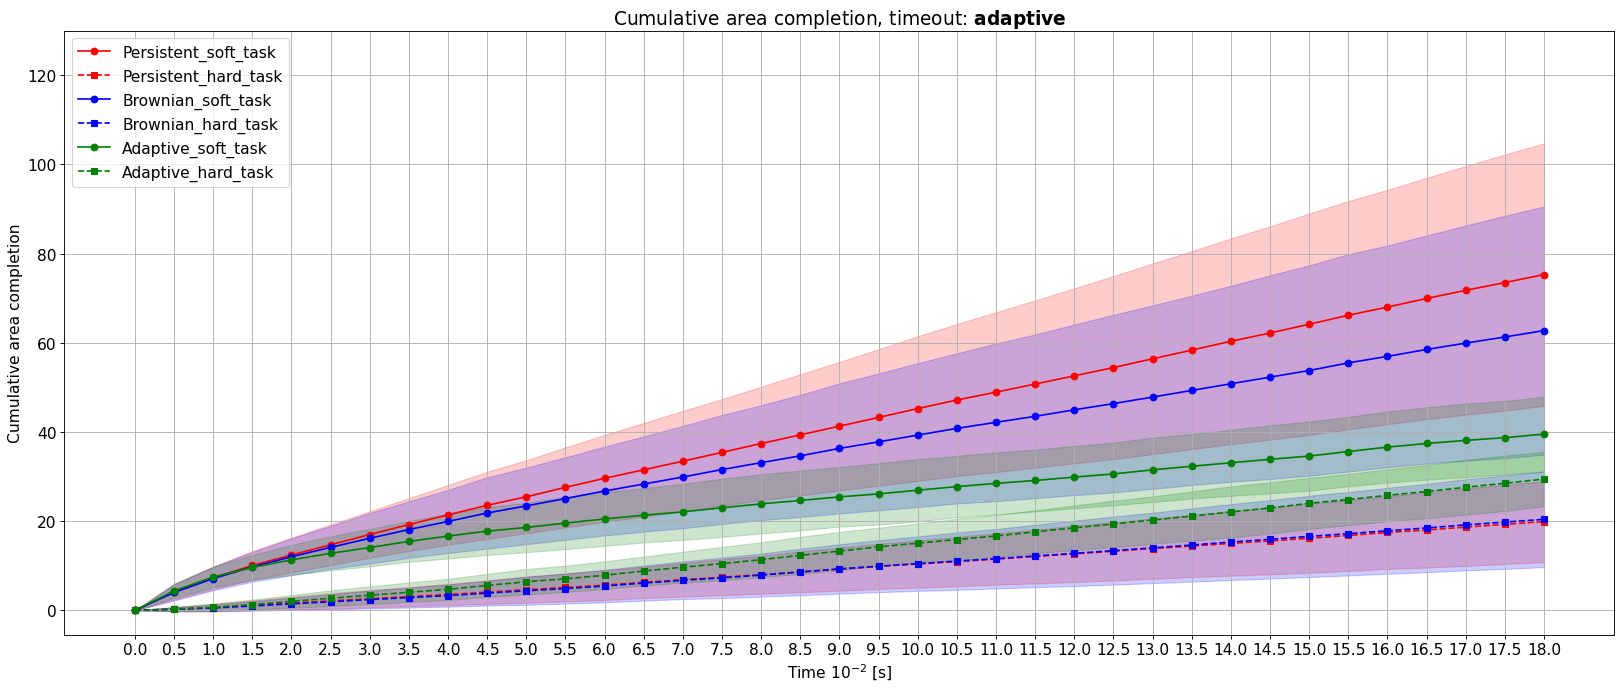

Saving figure:  adaptiveTimeout_cumulativeAreaCompletion_Mixed.png


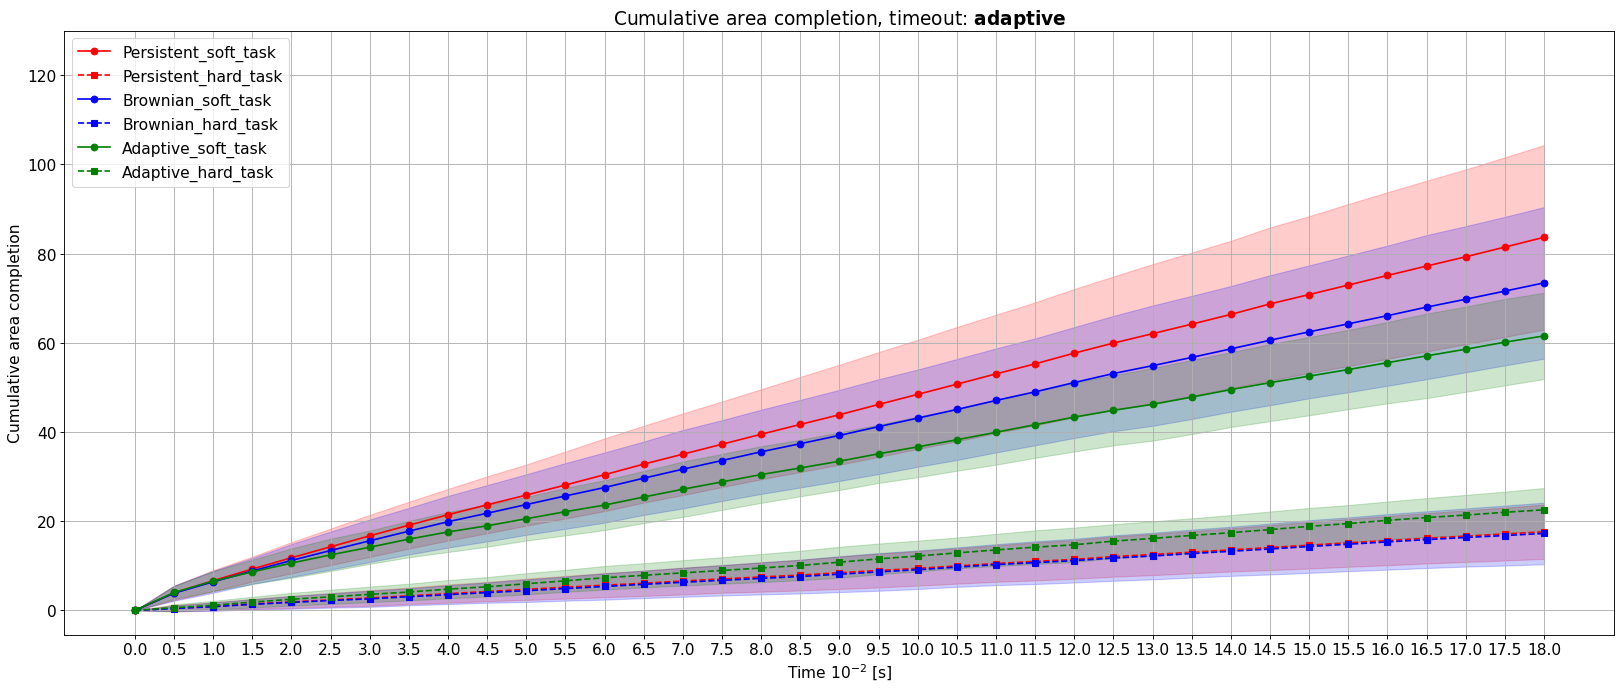

In [58]:
cumulative_plot(cumsums, bin_edges)